### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Master_Copy/ultralightbeam"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO]15:6:16 Generating bigrams
[INFO]15:6:16 Generating word bigrams
[INFO]15:6:21 Generated word bigrams
[INFO]15:6:22 Beginning lemmatization
[INFO]15:6:47 Ending lemmatization
[INFO]15:7:30 Issued perplexity: -9.42808103444275
[INFO]15:7:30 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.070*"mammal" + 0.041*"urban" + 0.033*"standard" + 0.031*"extinct" + 0.022*"gene" + 0.019*"peninsula" + 0.018*"phylogenetic" + 0.018*"difficulty" + 0.017*"taxonomy" + 0.016*"carnivore"'),
 (1,
  '0.033*"hunt" + 0.031*"people" + 0.019*"systematic" + 0.017*"climate_change" + 0.017*"climate" + 0.016*"valley" + 0.015*"climatic" + 0.013*"description" + 0.013*"arise" + 0.013*"inadequate"'),
 (2,
  '0.053*"nutrient" + 0.044*"social" + 0.037*"flower" + 0.035*"pollen" + 0.022*"concentration" + 0.019*"semi_natural" + 0.015*"adoption" + 0.013*"trait" + 0.013*"competition" + 0.013*"fluctuation"'),
 (3,
  '0.040*"bird" + 0.024*"population" + 0.016*"year" + 0.016*"wildlife" + 0.016*"decline" + 0.013*"km" + 0.011*"wetland" + 0.011*"nest" + 0.010*"fire" + 0.010*"animal"'),
 (4,
  '0.030*"conservation" + 0.020*"biodiversity" + 0.009*"protect" + 0.008*"management" + 0.007*"resource" + 0.007*"base" + 0.007*"datum" + 0.006*"reserve" + 0.006*"information" + 0.006*"development"'),
 (5,
  '0.068*"so

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(2,
  [('conservation', 0.05761298620659068),
   ('biodiversity', 0.03858606466492216),
   ('management', 0.015944471548321286),
   ('research', 0.015833592052157716),
   ('knowledge', 0.012795493857275913),
   ('approach', 0.011331884507916796),
   ('develop', 0.009402581274670687),
   ('paper', 0.009402581274670687),
   ('policy', 0.009336053576972547),
   ('global', 0.00895906329001641)]),
 (7,
  [('community', 0.01749506299891525),
   ('level', 0.016465941646037884),
   ('water', 0.014491141212138068),
   ('show', 0.01368453258420716),
   ('increase', 0.013044808499986092),
   ('richness', 0.0126832253219481),
   ('assemblage', 0.012599783050093178),
   ('river', 0.010986565794231358),
   ('wetland', 0.010124328985063833),
   ('fish', 0.009484604900842767)]),
 (10,
  [('change', 0.04207128099173554),
   ('ecosystem', 0.027350206611570248),
   ('biodiversity', 0.026549586776859504),
   ('impact', 0.02634297520661157),
   ('ecological', 0.025464876033057852),
   ('loss', 0.015754132

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.45573368804644265


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

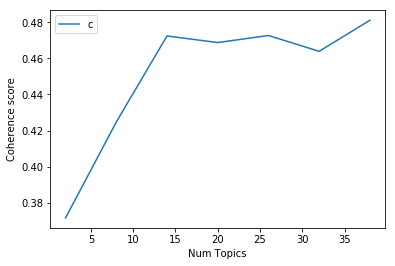

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)
print(model_topics)

[(5, [('population', 0.07336604071505104), ('genetic', 0.022810579146224554), ('extinction', 0.013477696949190774), ('seed', 0.013026560649636271), ('suggest', 0.012237072125415891), ('collection', 0.011870523882027858), ('individual', 0.010376134889753566), ('threaten', 0.010291546833587097), ('decline', 0.009530254328088874), ('dispersal', 0.00916370608470084)]), (1, [('local', 0.028983265000902505), ('management', 0.021221732291586085), ('resource', 0.019880869497950027), ('conservation', 0.016915499858177974), ('protect', 0.016322425930223563), ('land', 0.013434413759315129), ('wildlife', 0.012377195018179006), ('natural', 0.011242618808179262), ('activity', 0.011139475516361104), ('human', 0.011062118047497486)]), (7, [('community', 0.01749506299891525), ('level', 0.016465941646037884), ('water', 0.014491141212138068), ('show', 0.01368453258420716), ('increase', 0.013044808499986092), ('richness', 0.0126832253219481), ('assemblage', 0.012599783050093178), ('river', 0.0109865657942

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.046*"distribution" + 0.037*"model" + 0.023*"pattern" + 0.023*"range" + '
  '0.019*"variable" + 0.018*"spatial" + 0.017*"scale" + 0.015*"datum" + '
  '0.015*"environmental" + 0.015*"result" + 0.014*"factor" + '
  '0.013*"occurrence" + 0.013*"analysis" + 0.012*"predict" + 0.011*"potential" '
  '+ 0.009*"future" + 0.009*"explain" + 0.009*"variation" + 0.009*"base" + '
  '0.009*"current" + 0.009*"area" + 0.008*"habitat" + 0.008*"show" + '
  '0.008*"climatic" + 0.008*"test" + 0.008*"analyse" + 0.007*"relationship" + '
  '0.007*"climate" + 0.007*"hypothesis" + 0.007*"suitable" + 0.006*"region" + '
  '0.006*"map" + 0.006*"identify" + 0.006*"good" + 0.006*"geographical" + '
  '0.006*"scenario" + 0.006*"estimate" + 0.005*"regional" + 0.005*"assess" + '
  '0.005*"characteristic"'),
 (1,
  '0.029*"local" + 0.021*"management" + 0.020*"resource" + '
  '0.017*"conservation" + 0.016*"protect" + 0.013*"land" + 0.012*"wildlife" + '
  '0.011*"natural" + 0.011*"activity" + 0.011*"human" + 0.010

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.3691,"change, ecosystem, biodiversity, impact, ecolo...",[Abstract: 'Maintenance of soil health is cent...
1,1,0.0,0.3961,"distribution, model, pattern, range, variable,...",[Abstract: 'Plant invasion is highly responsiv...
2,2,0.0,0.5303,"distribution, model, pattern, range, variable,...","[Abstract: 'Globally, treeline in mountain lan..."
3,3,7.0,0.2815,"community, level, water, show, increase, richn...",[Abstract: 'Forests play a crucial role by reg...
4,4,7.0,0.3355,"community, level, water, show, increase, richn...",[Abstract: 'The analysis of species distributi...
5,5,10.0,0.2303,"change, ecosystem, biodiversity, impact, ecolo...",[Abstract: 'The Himalayan ecosystem is one of ...
6,6,0.0,0.4274,"distribution, model, pattern, range, variable,...","[Abstract: 'In an era of climate change, predi..."
7,7,9.0,0.3291,"plant, region, native, endemic, area, island, ...",[Abstract: 'The relationship and its key predi...
8,8,7.0,0.4849,"community, level, water, show, increase, richn...",[Abstract: 'Climate change effects on Himalaya...
9,9,0.0,0.3259,"distribution, model, pattern, range, variable,...",[Abstract: 'With the threats of climate change...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,10.0,"change, ecosystem, biodiversity, impact, ecolo...",559.0,0.1181
1,0.0,"distribution, model, pattern, range, variable,...",369.0,0.0780
2,0.0,"distribution, model, pattern, range, variable,...",525.0,0.1109
3,7.0,"community, level, water, show, increase, richn...",364.0,0.0769
4,7.0,"community, level, water, show, increase, richn...",465.0,0.0982
5,10.0,"change, ecosystem, biodiversity, impact, ecolo...",323.0,0.0682
6,0.0,"distribution, model, pattern, range, variable,...",469.0,0.0991
7,9.0,"plant, region, native, endemic, area, island, ...",327.0,0.0691
8,7.0,"community, level, water, show, increase, richn...",418.0,0.0883
9,0.0,"distribution, model, pattern, range, variable,...",333.0,0.0704


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     37.817173        1       1 -0.317037  0.031738
4      31.456345        1       2 -0.297547  0.107870
10      8.202921        1       3 -0.204476 -0.055713
8       7.000277        1       4 -0.111004 -0.238273
3       5.913970        1       5 -0.097848  0.227758
6       2.851634        1       6 -0.001512 -0.232949
1       1.653463        1       7  0.148263  0.068872
9       1.638315        1       8  0.150440 -0.018081
5       1.173970        1       9  0.150620  0.053984
0       1.014442        1      10  0.185774  0.015144
7       0.663275        1      11  0.197799  0.018059
2       0.614215        1      12  0.196526  0.021592, topic_info=      Category         Freq            Term        Total  loglift  logprob
2722   Default  6696.000000          forest  6696.000000  30.0000  30.0000
8634   Default  3265.000000           plant  3265.000000  29.0000  29.0000
9584   Default  2826.000000      population  2826.000000  28.0000  28.0000
9959   Default  1942.000000            tree  1942.000000  27.0000  27.0000
12203  Default  5196.000000    conservation  5196.000000  26.0000  26.0000
22024  Default  3049.000000        richness  3049.000000  25.0000  25.0000
9830   Default  1030.000000            soil  1030.000000  24.0000  24.0000
22791  Default  1061.000000         endemic  1061.000000  23.0000  23.0000
20978  Default  1197.000000            bird  1197.000000  22.0000  22.0000
2193   Default  4824.000000         habitat  4824.000000  21.0000  21.0000
3682   Default  4765.000000       diversity  4765.000000  20.0000  20.0000
21814  Default  1629.000000    distribution  1629.000000  19.0000  19.0000
21280  Default   852.000000          island   852.000000  18.0000  18.0000
9335   Default  1031.000000            taxa  1031.000000  17.0000  17.0000
3967   Default  2217.000000            area  2217.000000  16.0000  16.0000
2142   Default  1560.000000          region  1560.000000  15.0000  15.0000
19975  Default  2767.000000          number  2767.000000  14.0000  14.0000
7793   Default  3750.000000    biodiversity  3750.000000  13.0000  13.0000
10800  Default   617.000000          native   617.000000  12.0000  12.0000
5251   Default  3193.000000            site  3193.000000  11.0000  11.0000
3979   Default  1527.000000          change  1527.000000  10.0000  10.0000
13548  Default   828.000000            rare   828.000000   9.0000   9.0000
19096  Default   841.000000         genetic   841.000000   8.0000   8.0000
16903  Default  1158.000000           model  1158.000000   7.0000   7.0000
8078   Default   761.000000            seed   761.000000   6.0000   6.0000
13485  Default  1475.000000           total  1475.000000   5.0000   5.0000
12036  Default   831.000000            plot   831.000000   4.0000   4.0000
16972  Default  1638.000000          sample  1638.000000   3.0000   3.0000
3500   Default  1155.000000           range  1155.000000   2.0000   2.0000
13244  Default  1459.000000         pattern  1459.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
21625  Topic12    69.405220   concentration    70.590538   5.0756  -3.7949
14747  Topic12    57.891911    semi_natural    59.077209   5.0723  -3.9763
10966  Topic12    45.515293        adoption    46.700695   5.0669  -4.2168
13033  Topic12    40.166451     competition    41.351749   5.0635  -4.3419
19881  Topic12    37.235420           sheep    38.420746   5.0612  -4.4176
18517  Topic12    35.814816      pollinator    37.000103   5.0600  -4.4565
17460  Topic12    35.456909             bee    36.642227   5.0597  -4.4666
10045  Topic12    31.337463     pollination    32.522755   5.0555  -4.5901
15861  Topic12    29.019400        constant    30.204737   5.0525  -4.6669
11968  Topic12    27.772173     predominant    28.957518   5.0508  -4.7109
2927   Topic12    22.861277       technical    24.0

In [38]:
topics = optimal_model.show_topics(num_topics = -1, formatted=False)

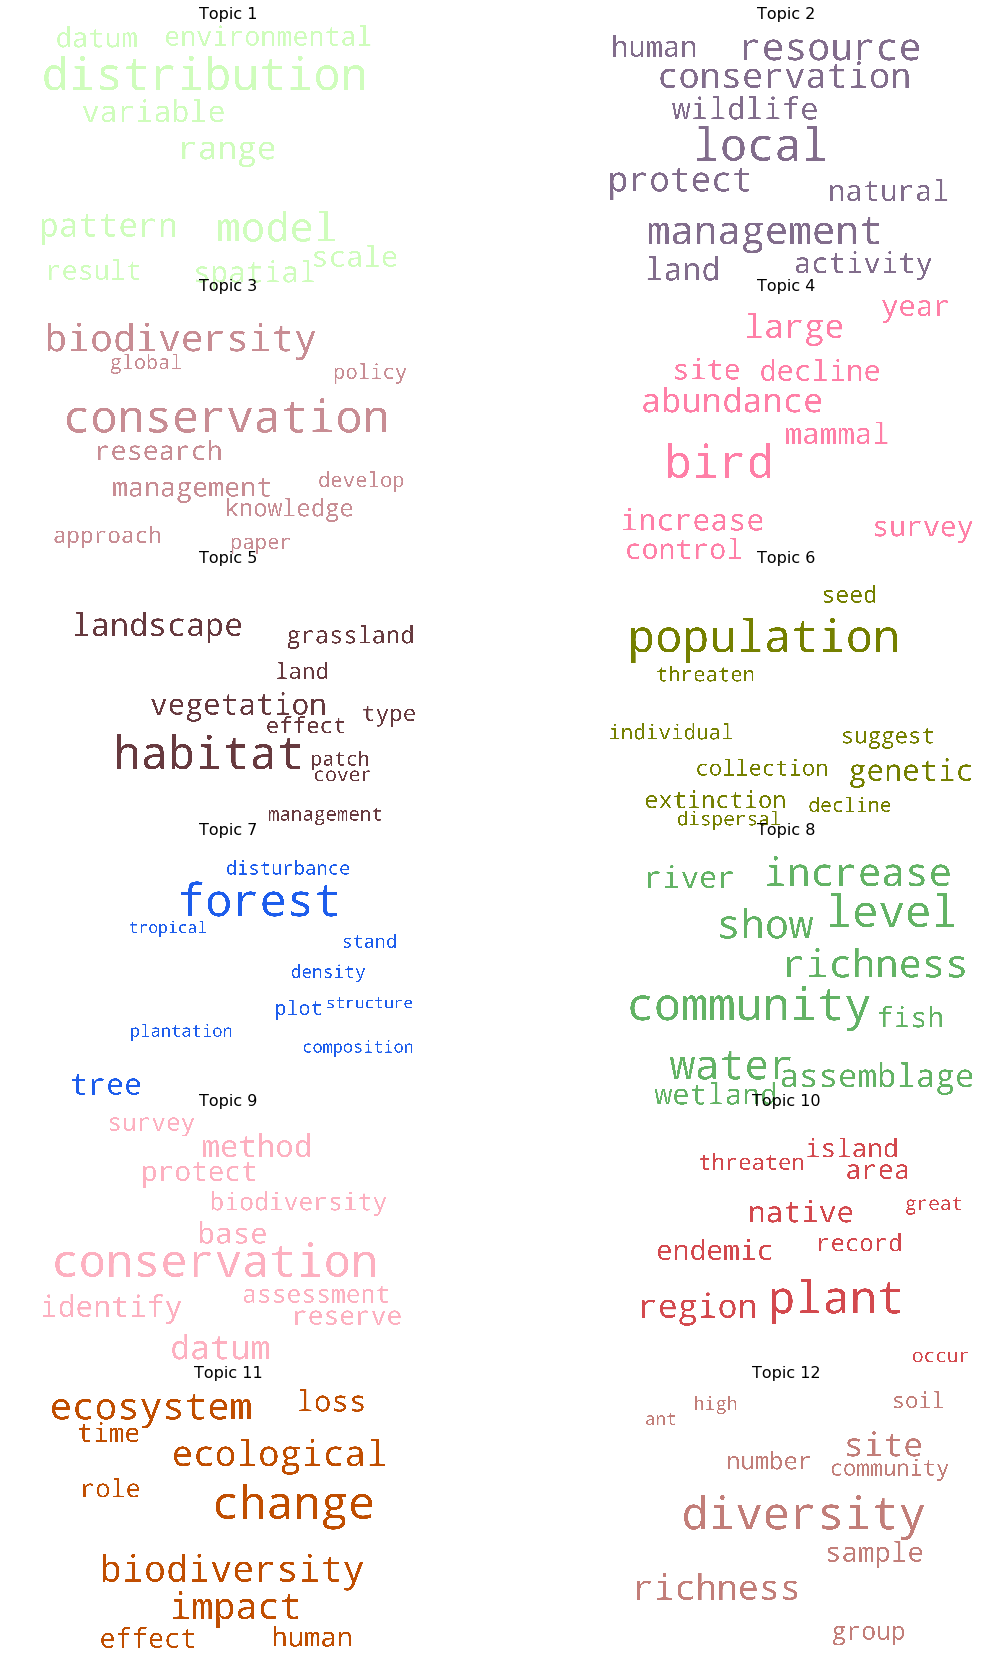

In [39]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab8',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(6, 2, figsize = (20, 30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

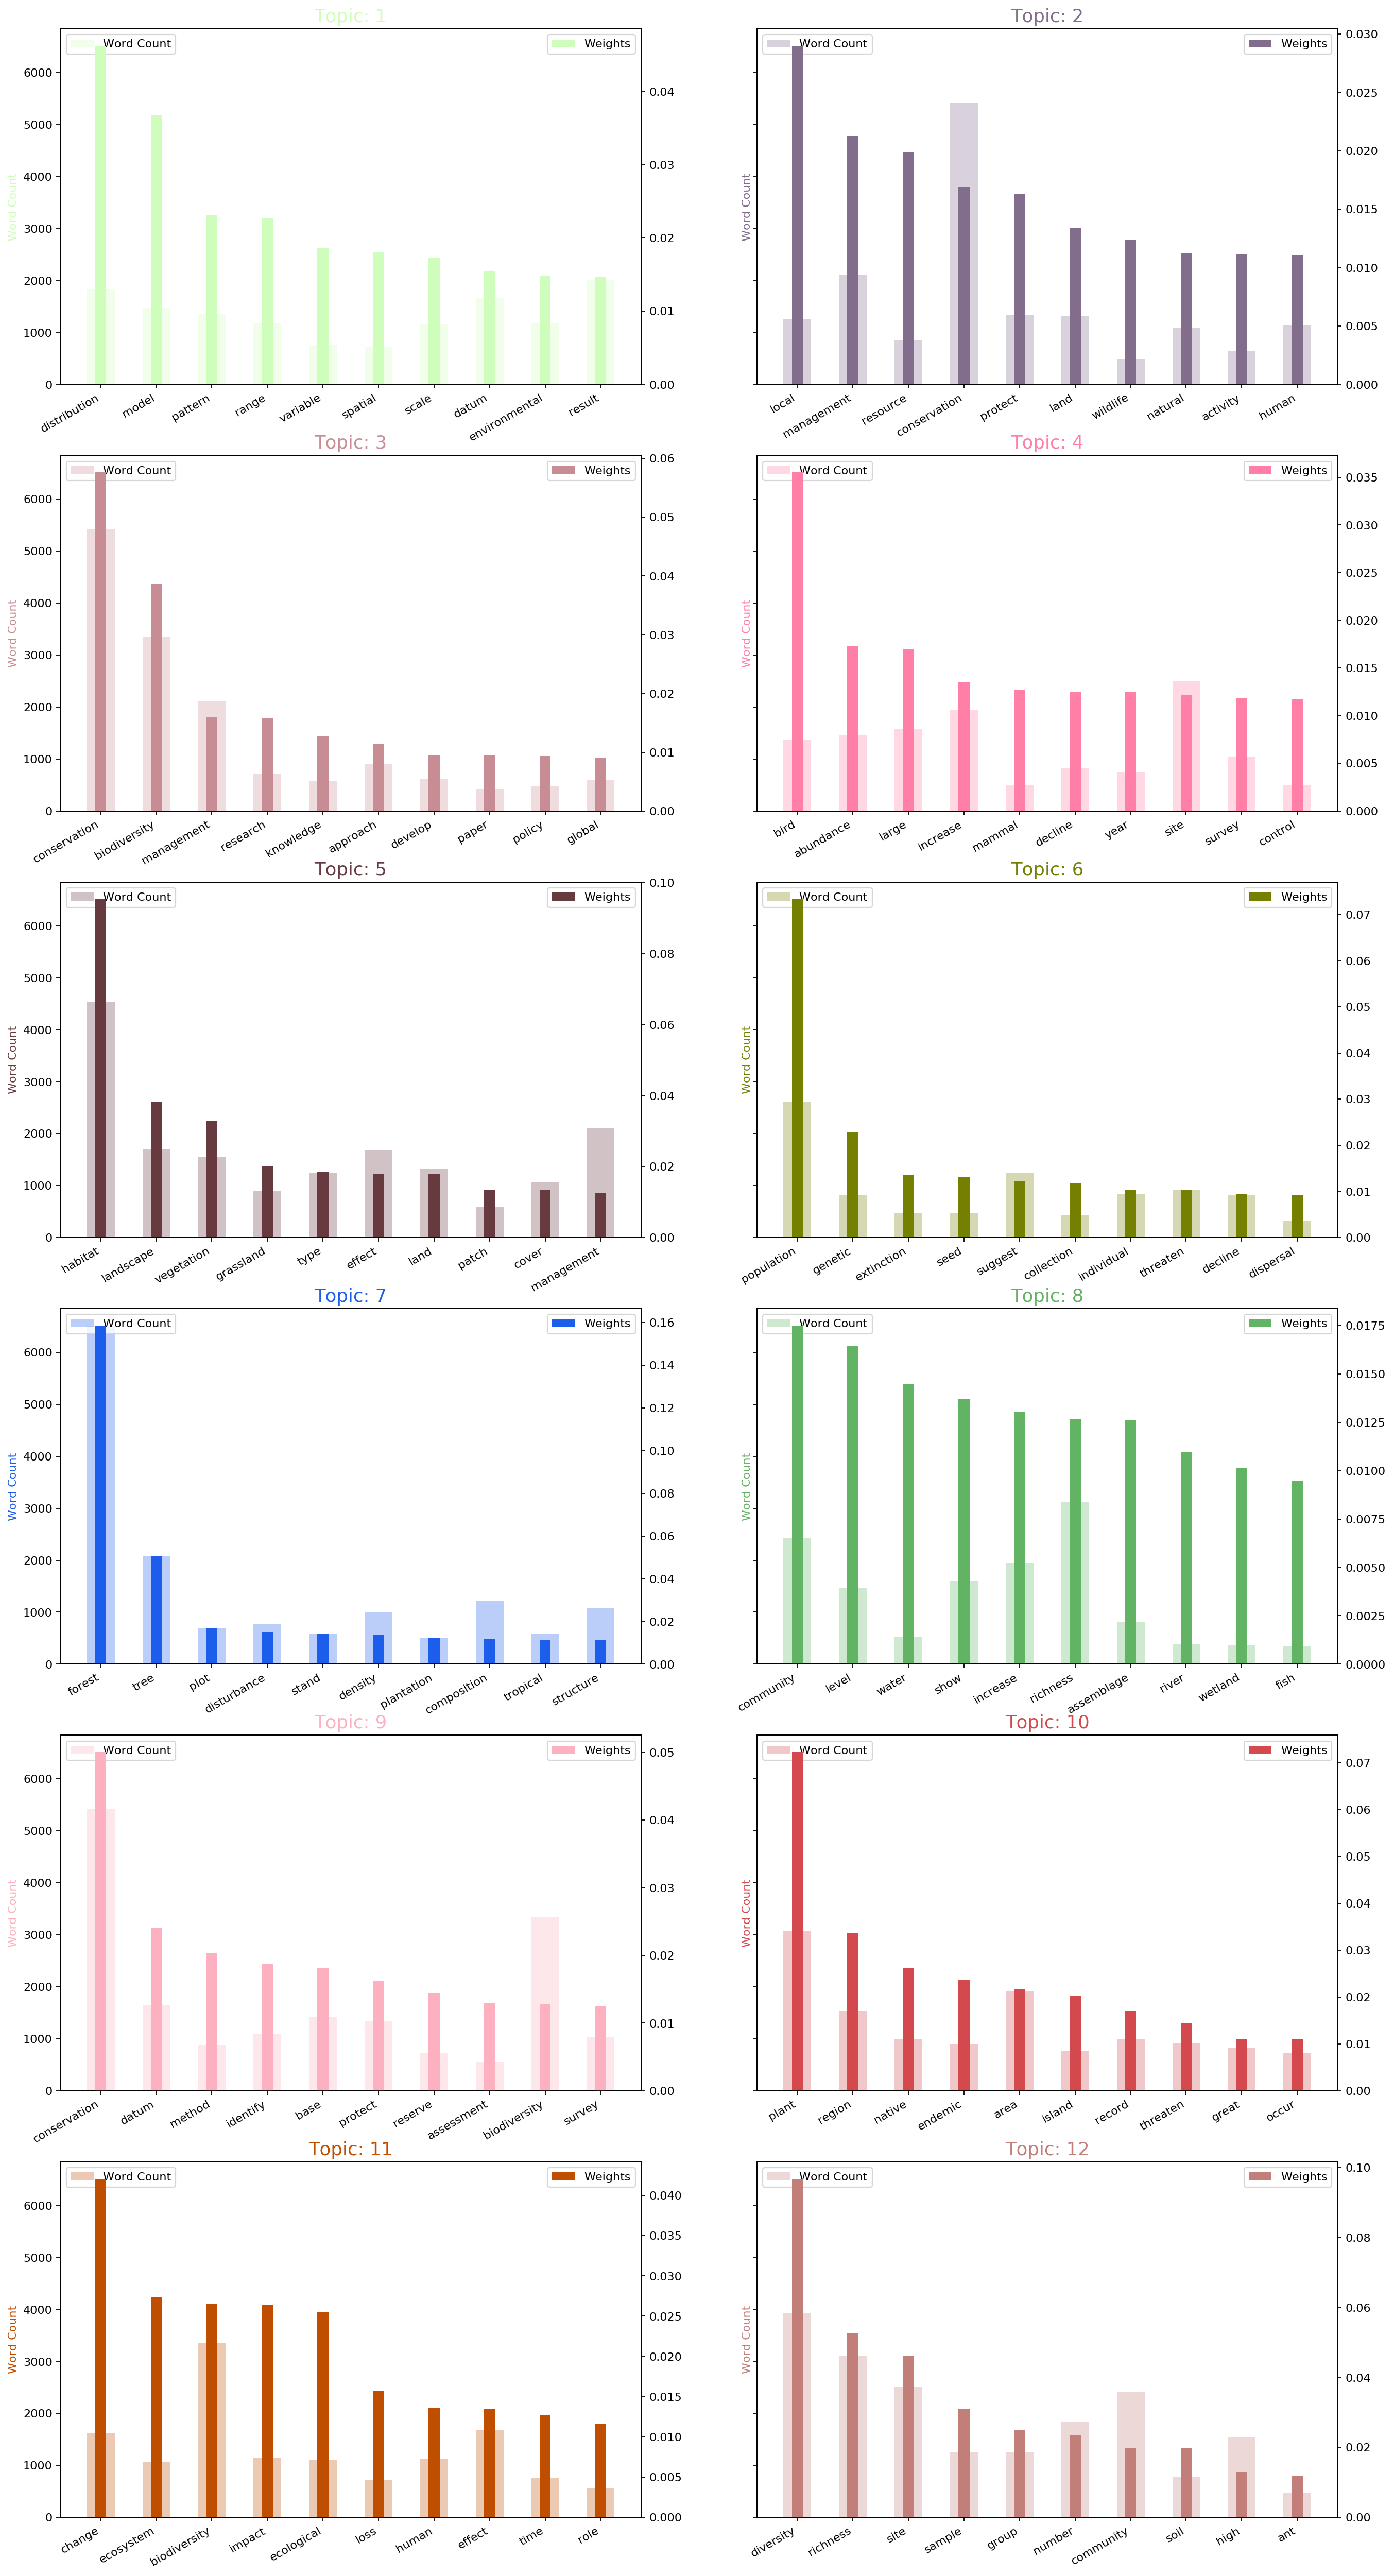

In [40]:
from collections import Counter
topics = optimal_model.show_topics(num_topics = -1, formatted=False)
data_flat = [w for w_list in textual_data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 2, figsize=(20, 40), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=True)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
plt.savefig('CorpusTopic12.pdf')
plt.show()